## In this notebook we convert the data to a processed format to be able to better work with the data.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import collections
import os

In [2]:
processed_folder_path = os.path.join("..", "data", "processed")
unprocessed_folder_path = os.path.join("..", "data", "unprocessed")

In [3]:
def pandas_eda(df):
    print("First 5 columns")
    print(df.head())
    print("*" * 100)
    print("Dataframe information")
    print(df.info())
    print("*" * 100)
    print("Missing values")
    print(df.isnull().sum())
    print("*" * 100)

### ENSO Index

We include the ENSO index as a column denoting a wet year, dry year or normal year.

$
flag = \begin{cases}
    -1, \text{if } \text{ ENSO } < -0.5 \\
    0, \text{if } 0.5 < \text{ ENSO } < 0.5 \\
    1, \text{if } \text{ ENSO } > 0.5
\end{cases}
$

with -1 denoting a dry year, 0 denoting a normal year and 1 denoting a wet year.

In [4]:
df = pd.read_excel(os.path.join(unprocessed_folder_path, "Data_ENSO", "ENSO evolution.xlsx"), skiprows=2)

# df["avg"] = df.loc[:, df.columns != "Year"].mean(axis=1)

year_data = collections.defaultdict(list)

for index, row in df.iterrows():
    year = row["Year"]
    # Add only months that are in the corresponding hydrological year
    year_data[year - 1].extend(row[1:4].values)
    year_data[year].extend(row[4:].values)

year_indices = {}

# Here we also consider 1949 and 2021, even though we don't 
# have full data for those hydrological years yet
for year, enso_indices in year_data.items():
    avg_enso_index = np.mean(enso_indices)

    # Determine "wetness" of year
    if avg_enso_index < -0.5:
        index = -1
    elif -0.5 < avg_enso_index < 0.5:
        index = 0
    elif avg_enso_index > 0.5:
        index = 1

    year_indices[year] = index

print(year_indices)

{1949.0: -1, 1950.0: -1, 1951.0: 1, 1952.0: 0, 1953.0: 1, 1954.0: -1, 1955.0: -1, 1956.0: 0, 1957.0: 1, 1958.0: 1, 1959.0: 0, 1960.0: 0, 1961.0: 0, 1962.0: 0, 1963.0: 1, 1964.0: -1, 1965.0: 1, 1966.0: 0, 1967.0: 0, 1968.0: 1, 1969.0: 1, 1970.0: -1, 1971.0: -1, 1972.0: 1, 1973.0: -1, 1974.0: -1, 1975.0: -1, 1976.0: 0, 1977.0: 0, 1978.0: 0, 1979.0: 0, 1980.0: 0, 1981.0: 0, 1982.0: 1, 1983.0: 0, 1984.0: -1, 1985.0: 0, 1986.0: 1, 1987.0: 1, 1988.0: -1, 1989.0: 0, 1990.0: 0, 1991.0: 1, 1992.0: 0, 1993.0: 0, 1994.0: 1, 1995.0: -1, 1996.0: 0, 1997.0: 1, 1998.0: -1, 1999.0: -1, 2000.0: -1, 2001.0: 0, 2002.0: 1, 2003.0: 0, 2004.0: 1, 2005.0: 0, 2006.0: 0, 2007.0: -1, 2008.0: -1, 2009.0: 1, 2010.0: -1, 2011.0: -1, 2012.0: 0, 2013.0: 0, 2014.0: 0, 2015.0: 1, 2016.0: 0, 2017.0: 0, 2018.0: 0, 2019.0: 0, 2020.0: -1, 2021.0: -1}


#### Here I plot some information about the distribution of years

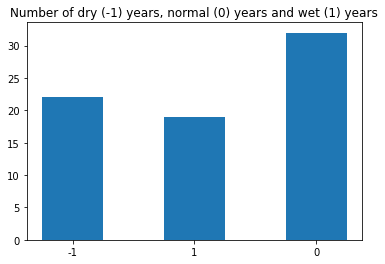

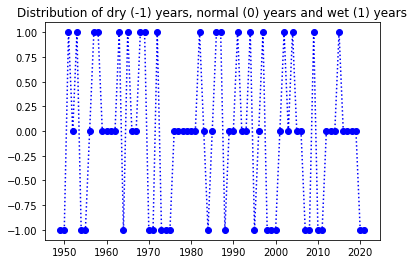

In [5]:
counter = collections.Counter(year_indices.values())
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, align="edge") 
plt.title("Number of dry (-1) years, normal (0) years and wet (1) years")
plt.xticks(indexes + width * 0.5, labels)
plt.show()

plt.figure()
plt.plot(year_indices.keys(), year_indices.values(), 'ob:')
plt.title("Distribution of dry (-1) years, normal (0) years and wet (1) years")
plt.show()

### Convert data files from NDSI/NDVI to formatted CSVs

In [6]:
data_folder = "Data_NDSI_NDVI"
data_files = ["NDSI.txt", "NDVI.txt"]


for data_file in data_files:
    df = pd.read_csv(os.path.join(unprocessed_folder_path, data_folder, data_file), 
                     delimiter="\t", index_col=False,
                     names=["Watershed", "Subsubwatershed", "Product", "Date",
                            "Areaini", "Areareproj", "SurfNDSImax", "SurfNDSImin",
                            "SurfNDSIavg", "NDSImax", "NDSImin", "NDSIavg",
                            "Surfcloudmax", "Surfcloudmin", "Surfcloudavg",
                            "Surfbadpixmax", "Surfbadpixmin", "Surfbadpixavg"])
    
    # Convert date to datetime and convert to wateryears
    df["date"] = pd.to_datetime(df["Date"])
    df.drop("Date", axis=1)
    df["water_year"] = df["date"].dt.year.where(df["date"].dt.month > 3, df["date"].dt.year - 1)
    
    # Add year_type column, determining wetness of year
    df["year_type"] = df['water_year'].map(year_indices)
    df.to_csv(os.path.join(processed_folder_path, data_file[:4] + ".csv"))

### Convert data from the river flow dataset to properly formatted CSV

In [7]:
flow_data_folder = "Data_RiverFlow"
flow_data_file = "DGA.txt"

date_columns = ["day", "month", "year", "hour"]

df = pd.read_csv(os.path.join(unprocessed_folder_path, flow_data_folder, flow_data_file), 
                 delimiter="\t", index_col=False,
                 names=["station_number", "day", "month", "year", "hour", 
                        "river_height", "river_flow", "information", "origin"])

# Convert date go datetime and add as column
date = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hour=df.hour))
df = df.drop(columns=date_columns)
df.insert(1, 'date', date)
df["water_year"] = df["date"].dt.year.where(df["date"].dt.month > 3, df["date"].dt.year - 1)


# Add year_type column, determining wetness of year
df["year_type"] = df['water_year'].map(year_indices)

df.to_csv(os.path.join(processed_folder_path, flow_data_file[:3] + ".csv"))